In [1]:
import numpy as np
from qutip import destroy, tensor, qeye, average_gate_fidelity
from qutip_qip.operations import ISWAP, SQRTISWAP
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import tri
from matplotlib.colors import TwoSlopeNorm
import lovelyplots
import scienceplots
import numpy as np
from qutip import destroy, tensor, qeye, average_gate_fidelity
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.tri as tri

In [2]:
# Parameters for the simulation
target_fidelity = 0.99  # Target fidelity (e.g., 99%)
N = 100  # Number of data points for fidelity plots
g3 = 60e6  # Coupling strength g3 = 60 MHz
n_s_list = np.linspace(2, 5, N)  # Pump photon number values
delta_list = 1e6 * np.linspace(50, 250, N)  # Detuning values in Hz

# iSWAP and sqrt(iSWAP combinations)
iswap_choices = [True, False]  # True for iSWAP, False for sqrt(iSWAP)
lambdaqs = [0.08, 0.1]  # Different lambda values
T1_values = [50e-6, 100e-6]  # T1 values in seconds

# Define ladder operators for the qubits
q = destroy(2)
q1 = tensor(q, qeye(2), qeye(2), qeye(2))
q2 = tensor(qeye(2), q, qeye(2), qeye(2))
q3 = tensor(qeye(2), qeye(2), q, qeye(2))
q4 = tensor(qeye(2), qeye(2), qeye(2), q)
q1dag, q2dag, q3dag, q4dag = q1.dag(), q2.dag(), q3.dag(), q4.dag()

# Interaction and spectator terms
interaction_term = q1dag * q2 + q1 * q2dag
spectator_prefactor = 1
spectator_term = q3dag * q4 + q3 * q4dag

In [3]:
# Data structure to hold all the results
data_store = []

# Step 1: Collect Data
for iswap_choice in iswap_choices:
    for lambdaq in lambdaqs:
        for T1 in T1_values:
            # Choose between iSWAP and sqrt(iSWAP)
            full_pulse = np.pi / 2 if iswap_choice else np.pi / 4
            intended_gate = (
                ISWAP([0, 1]).get_compact_qobj()
                if iswap_choice
                else SQRTISWAP([0, 1]).get_compact_qobj()
            )
            gate_type = "iSWAP" if iswap_choice else r"$\sqrt{iSWAP}$"

            # Fidelity and gate duration data storage
            fidelity_list = []
            n_s_points = []
            delta_points = []
            gate_durations = []

            # Fidelity calculation loop
            for delta in tqdm(
                delta_list,
                desc=f"Processing {gate_type}, lambda={lambdaq}, T1={T1*1e6} µs",
            ):
                for n_s in n_s_list:
                    eta = np.sqrt(n_s)
                    g_eff = 6 * eta * g3 * (lambdaq**2)  # Effective coupling
                    t_f = full_pulse / g_eff  # Gate duration in seconds
                    t_f_ns = t_f * 1e9  # Convert gate duration to nanoseconds

                    # Spectator term prefactor and integral term
                    multiple_scale_factor = np.sqrt(2)  # Crowding term
                    integral_term = (
                        2 / delta
                    )  # Worst-case, magnitude from time-dependent phase integral

                    # Time evolution operator U(t_f)
                    U_t_f = (
                        1j
                        * g_eff
                        * (
                            t_f * interaction_term
                            + multiple_scale_factor
                            * integral_term
                            * spectator_prefactor
                            * spectator_term
                        )
                    ).expm()

                    # Fidelity calculation with lifetime decay
                    target_iswap = tensor(intended_gate, qeye([2, 2]))
                    fidelity = 1 - (
                        average_gate_fidelity(U_t_f, target_iswap) * np.exp(-t_f / T1)
                    )

                    # Store data in lists
                    fidelity_list.append(fidelity)
                    n_s_points.append(eta)  # Use eta (sqrt of n_s) for plotting
                    delta_points.append(
                        delta / 1e6
                    )  # Convert delta to MHz for plotting
                    gate_durations.append(t_f_ns)  # Store gate duration in nanoseconds

            # Store all data in a dictionary
            data_store.append(
                {
                    "gate_type": gate_type,
                    "lambdaq": lambdaq,
                    "T1": T1,
                    "fidelity_list": np.array(fidelity_list),
                    "n_s_points": np.array(n_s_points),
                    "delta_points": np.array(delta_points),
                    "gate_durations": np.array(gate_durations),
                }
            )

Processing iSWAP, lambda=0.08, T1=50.0 µs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing iSWAP, lambda=0.08, T1=100.0 µs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing iSWAP, lambda=0.1, T1=50.0 µs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing iSWAP, lambda=0.1, T1=100.0 µs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing $\sqrt{iSWAP}$, lambda=0.08, T1=50.0 µs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing $\sqrt{iSWAP}$, lambda=0.08, T1=100.0 µs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing $\sqrt{iSWAP}$, lambda=0.1, T1=50.0 µs:   0%|          | 0/100 [00:00<?, ?it/s]

Processing $\sqrt{iSWAP}$, lambda=0.1, T1=100.0 µs:   0%|          | 0/100 [00:00<?, ?it/s]

Saved: iSWAP_lambda_008_T1_50_us.pdf


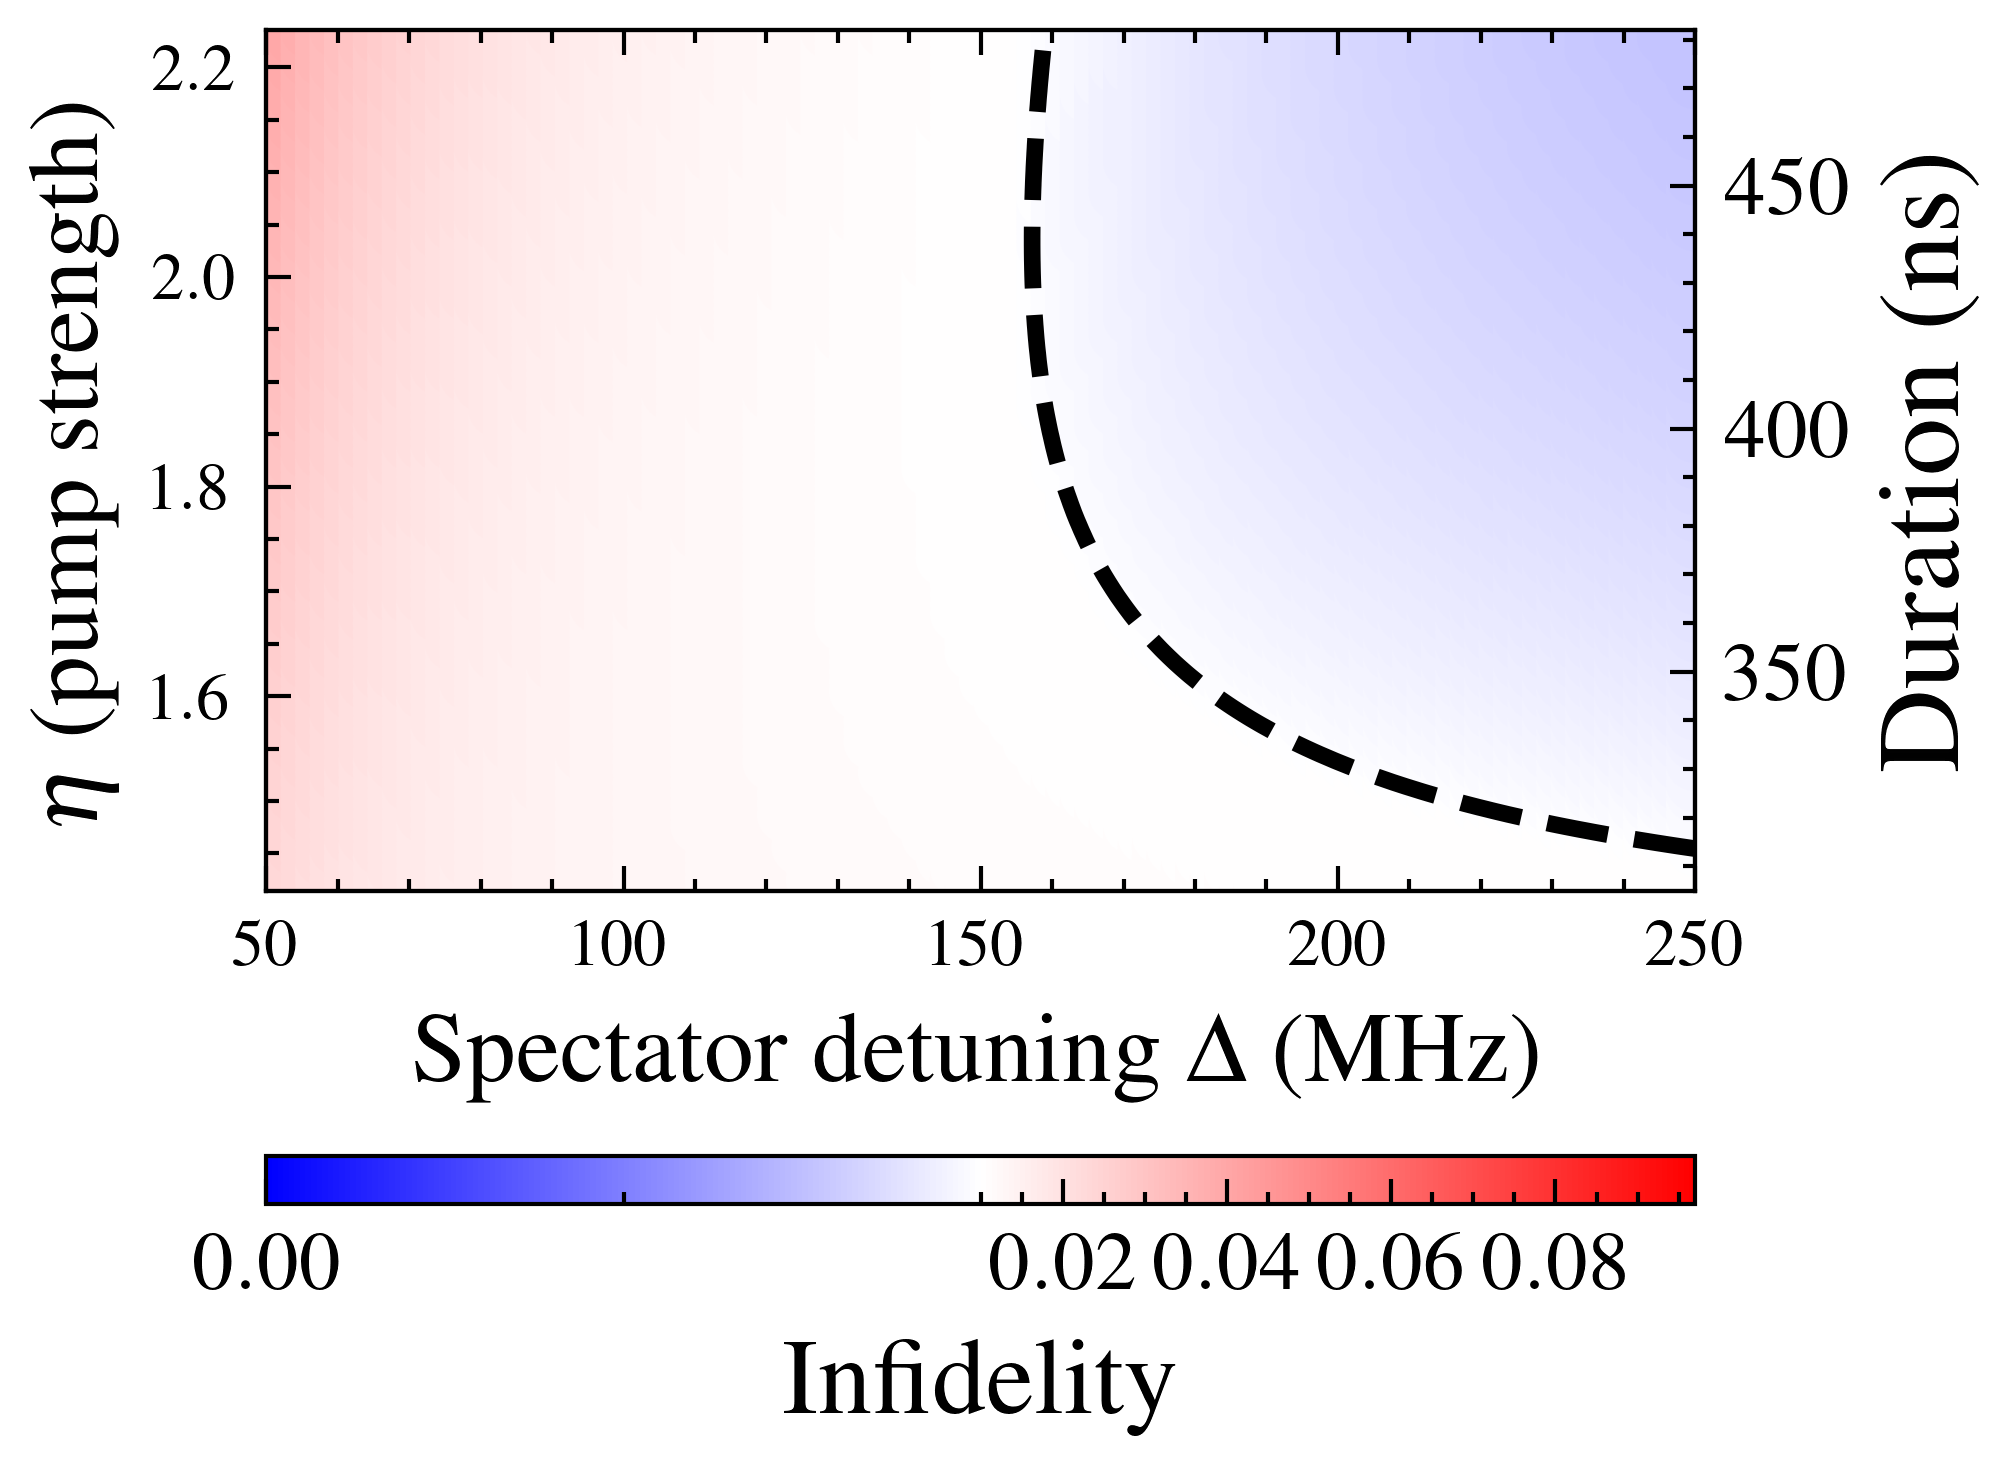

Saved: iSWAP_lambda_008_T1_100_us.pdf


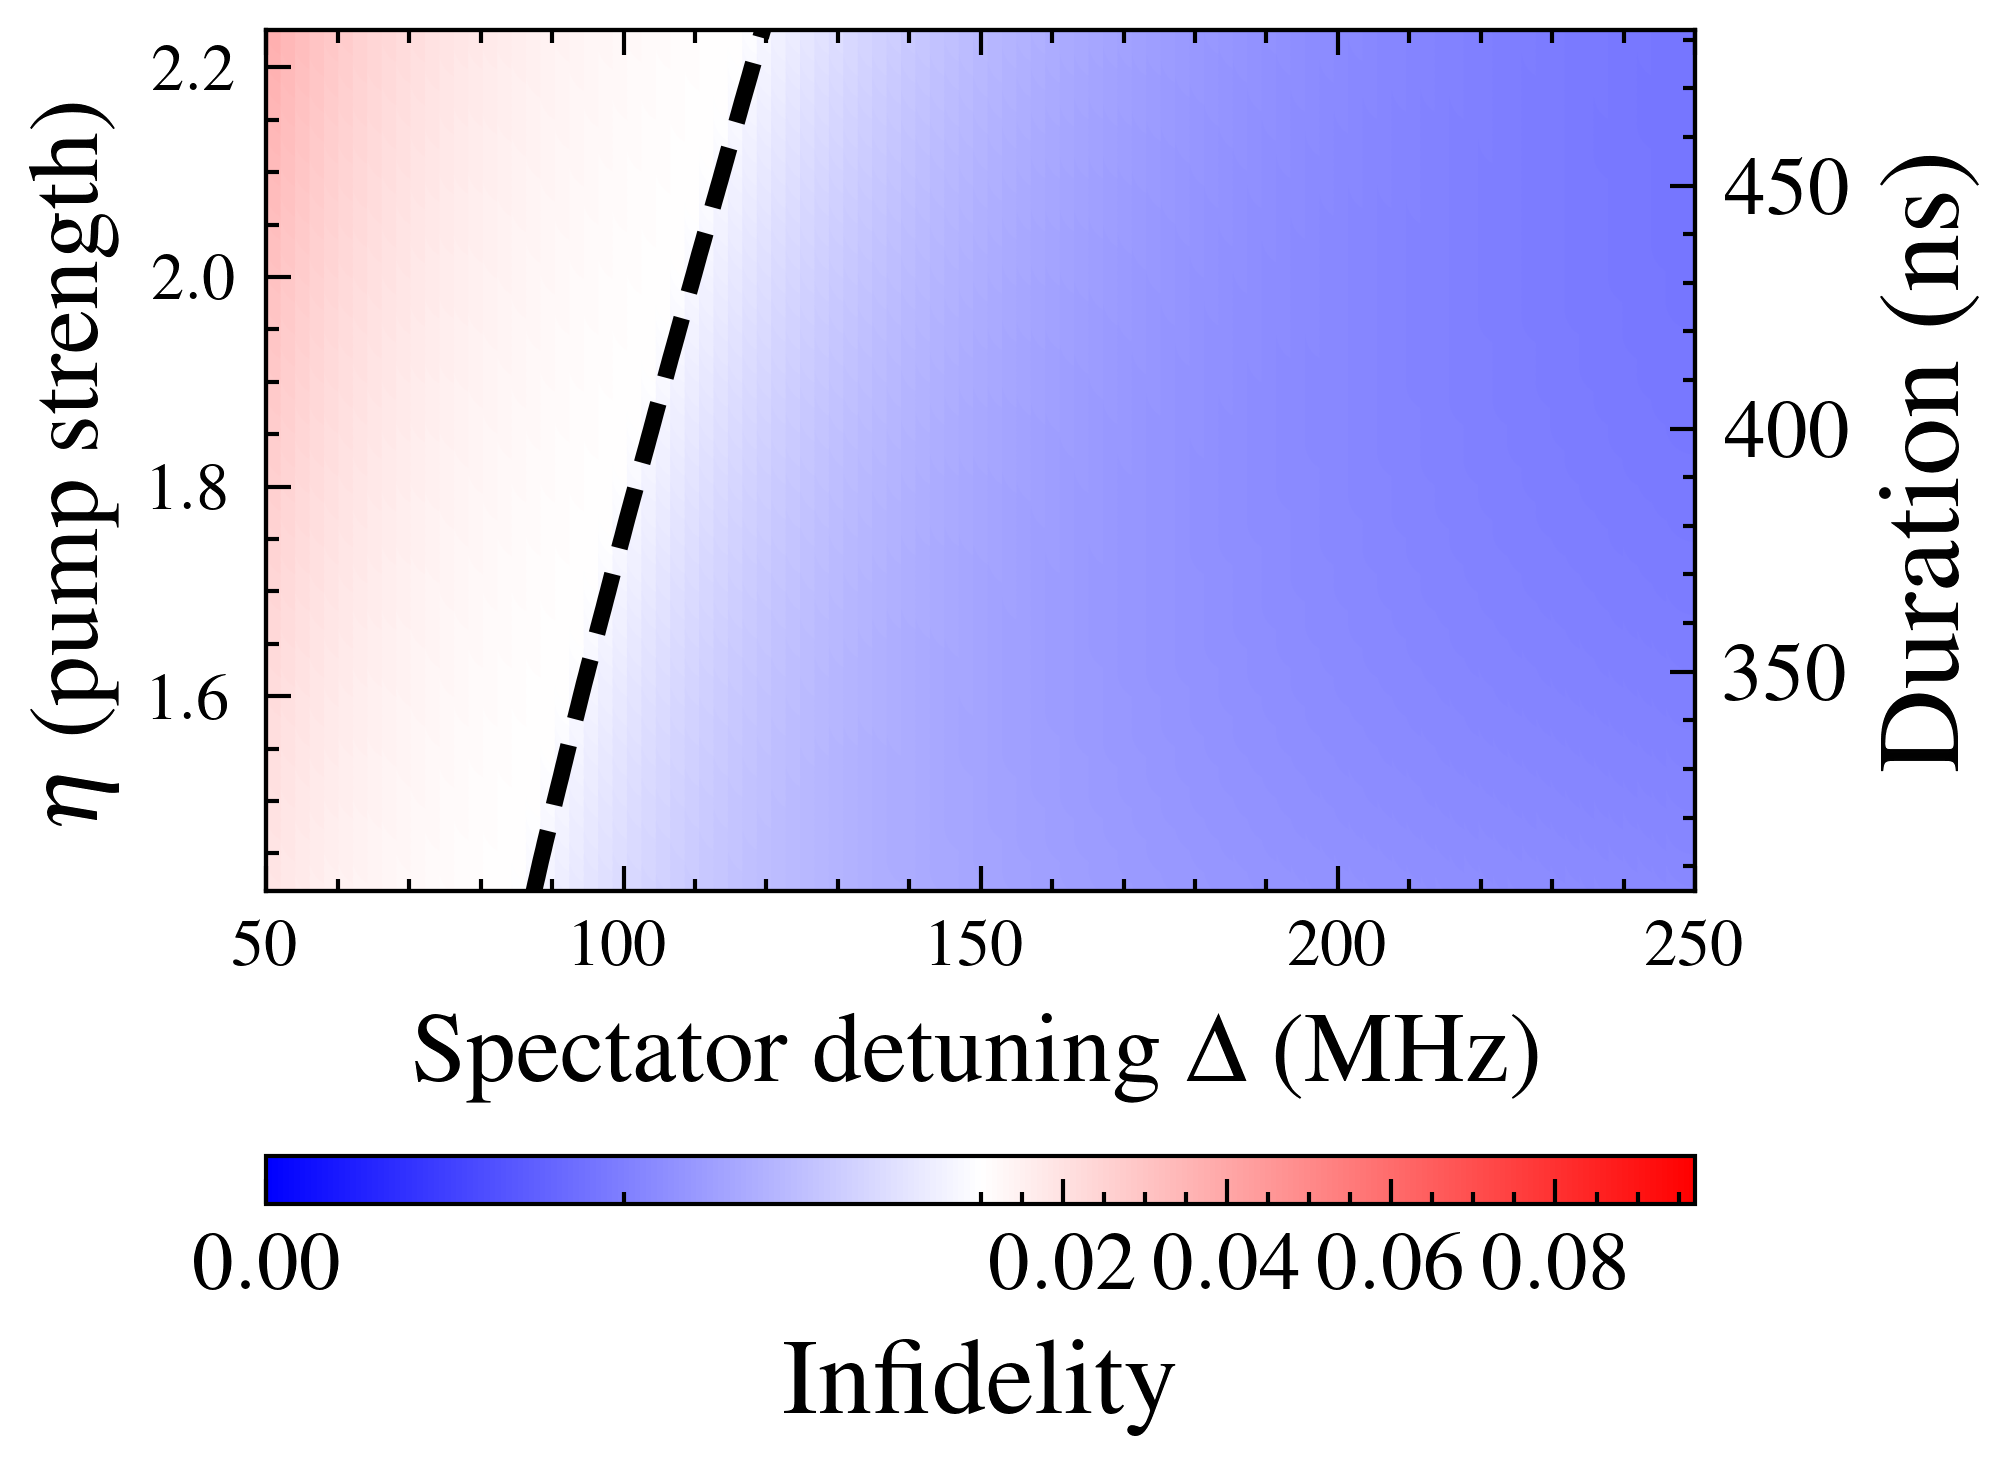

Saved: iSWAP_lambda_01_T1_50_us.pdf


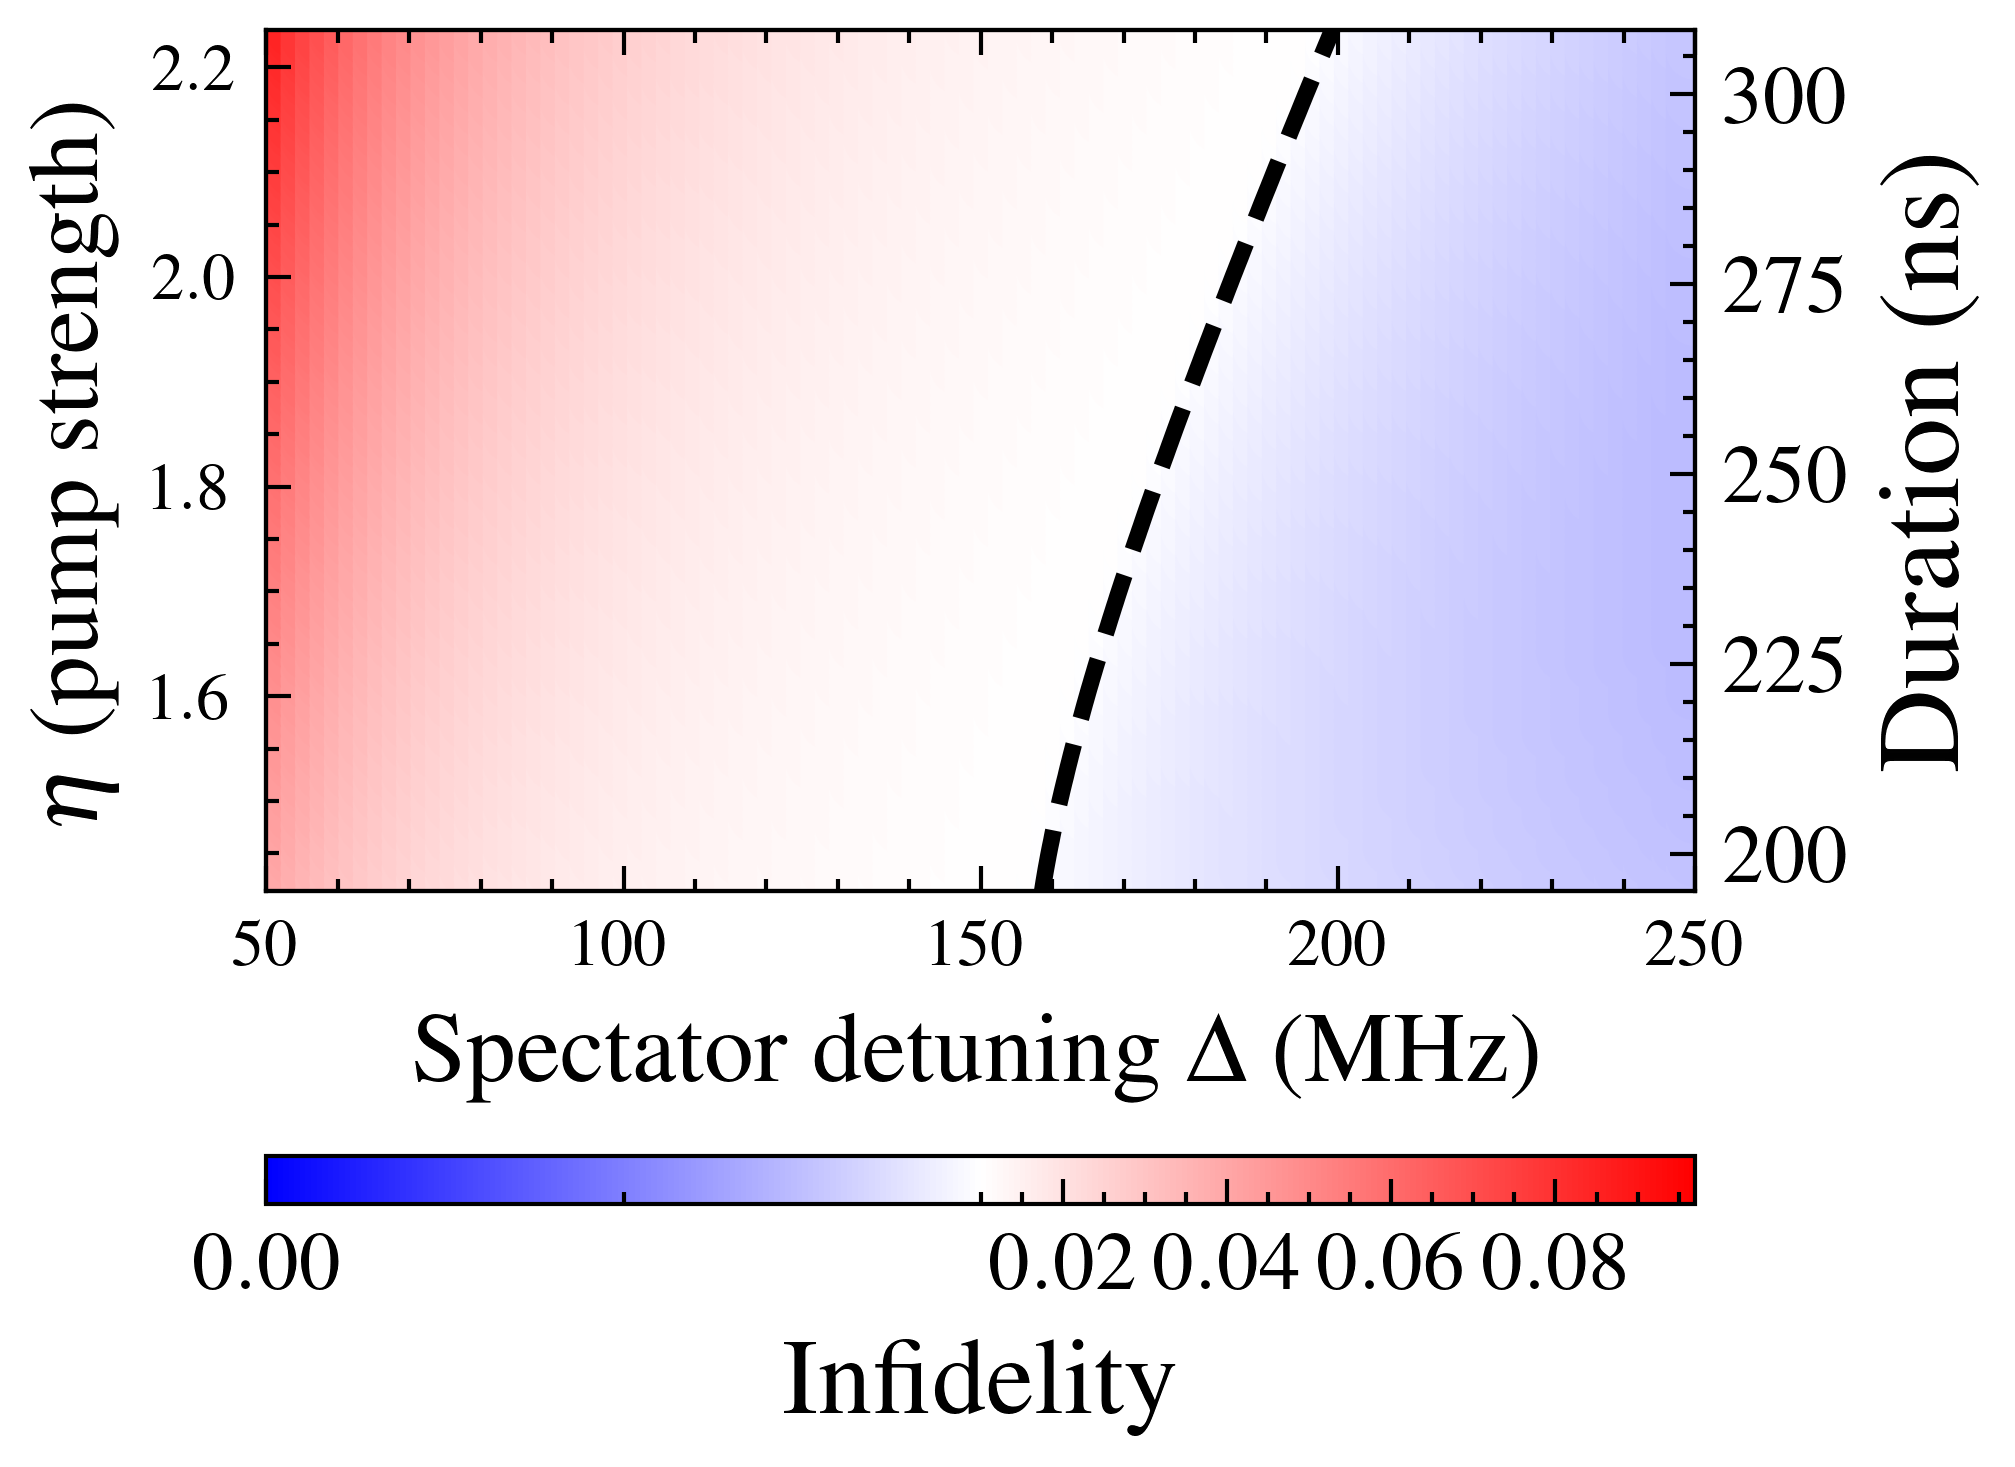

Saved: iSWAP_lambda_01_T1_100_us.pdf


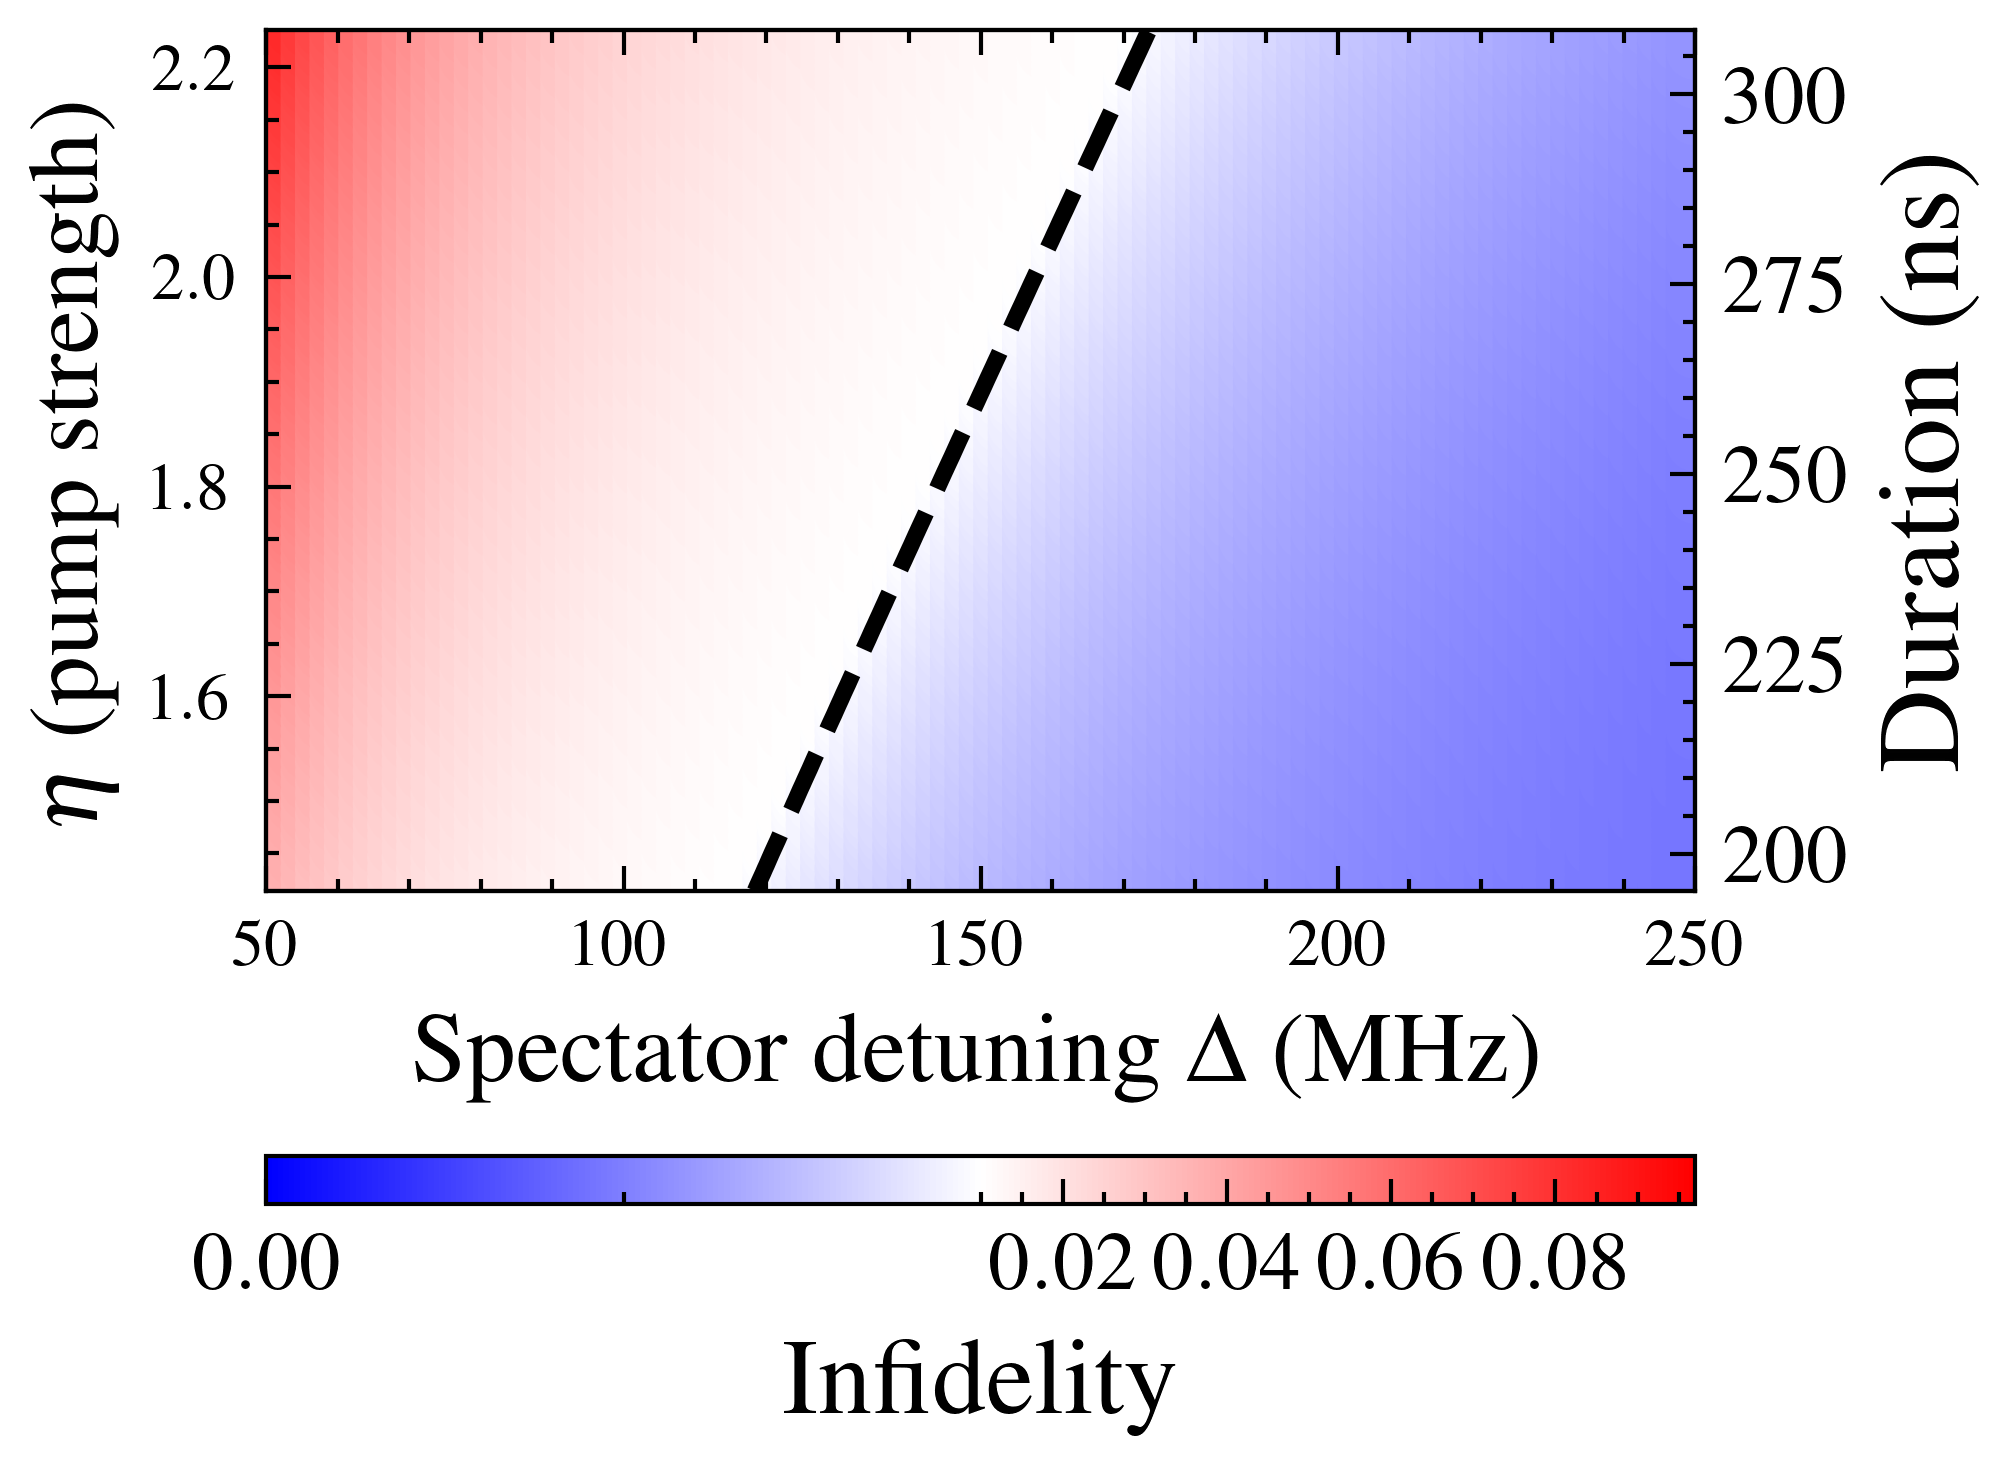

Saved: sqrt{iSWAP}_lambda_008_T1_50_us.pdf


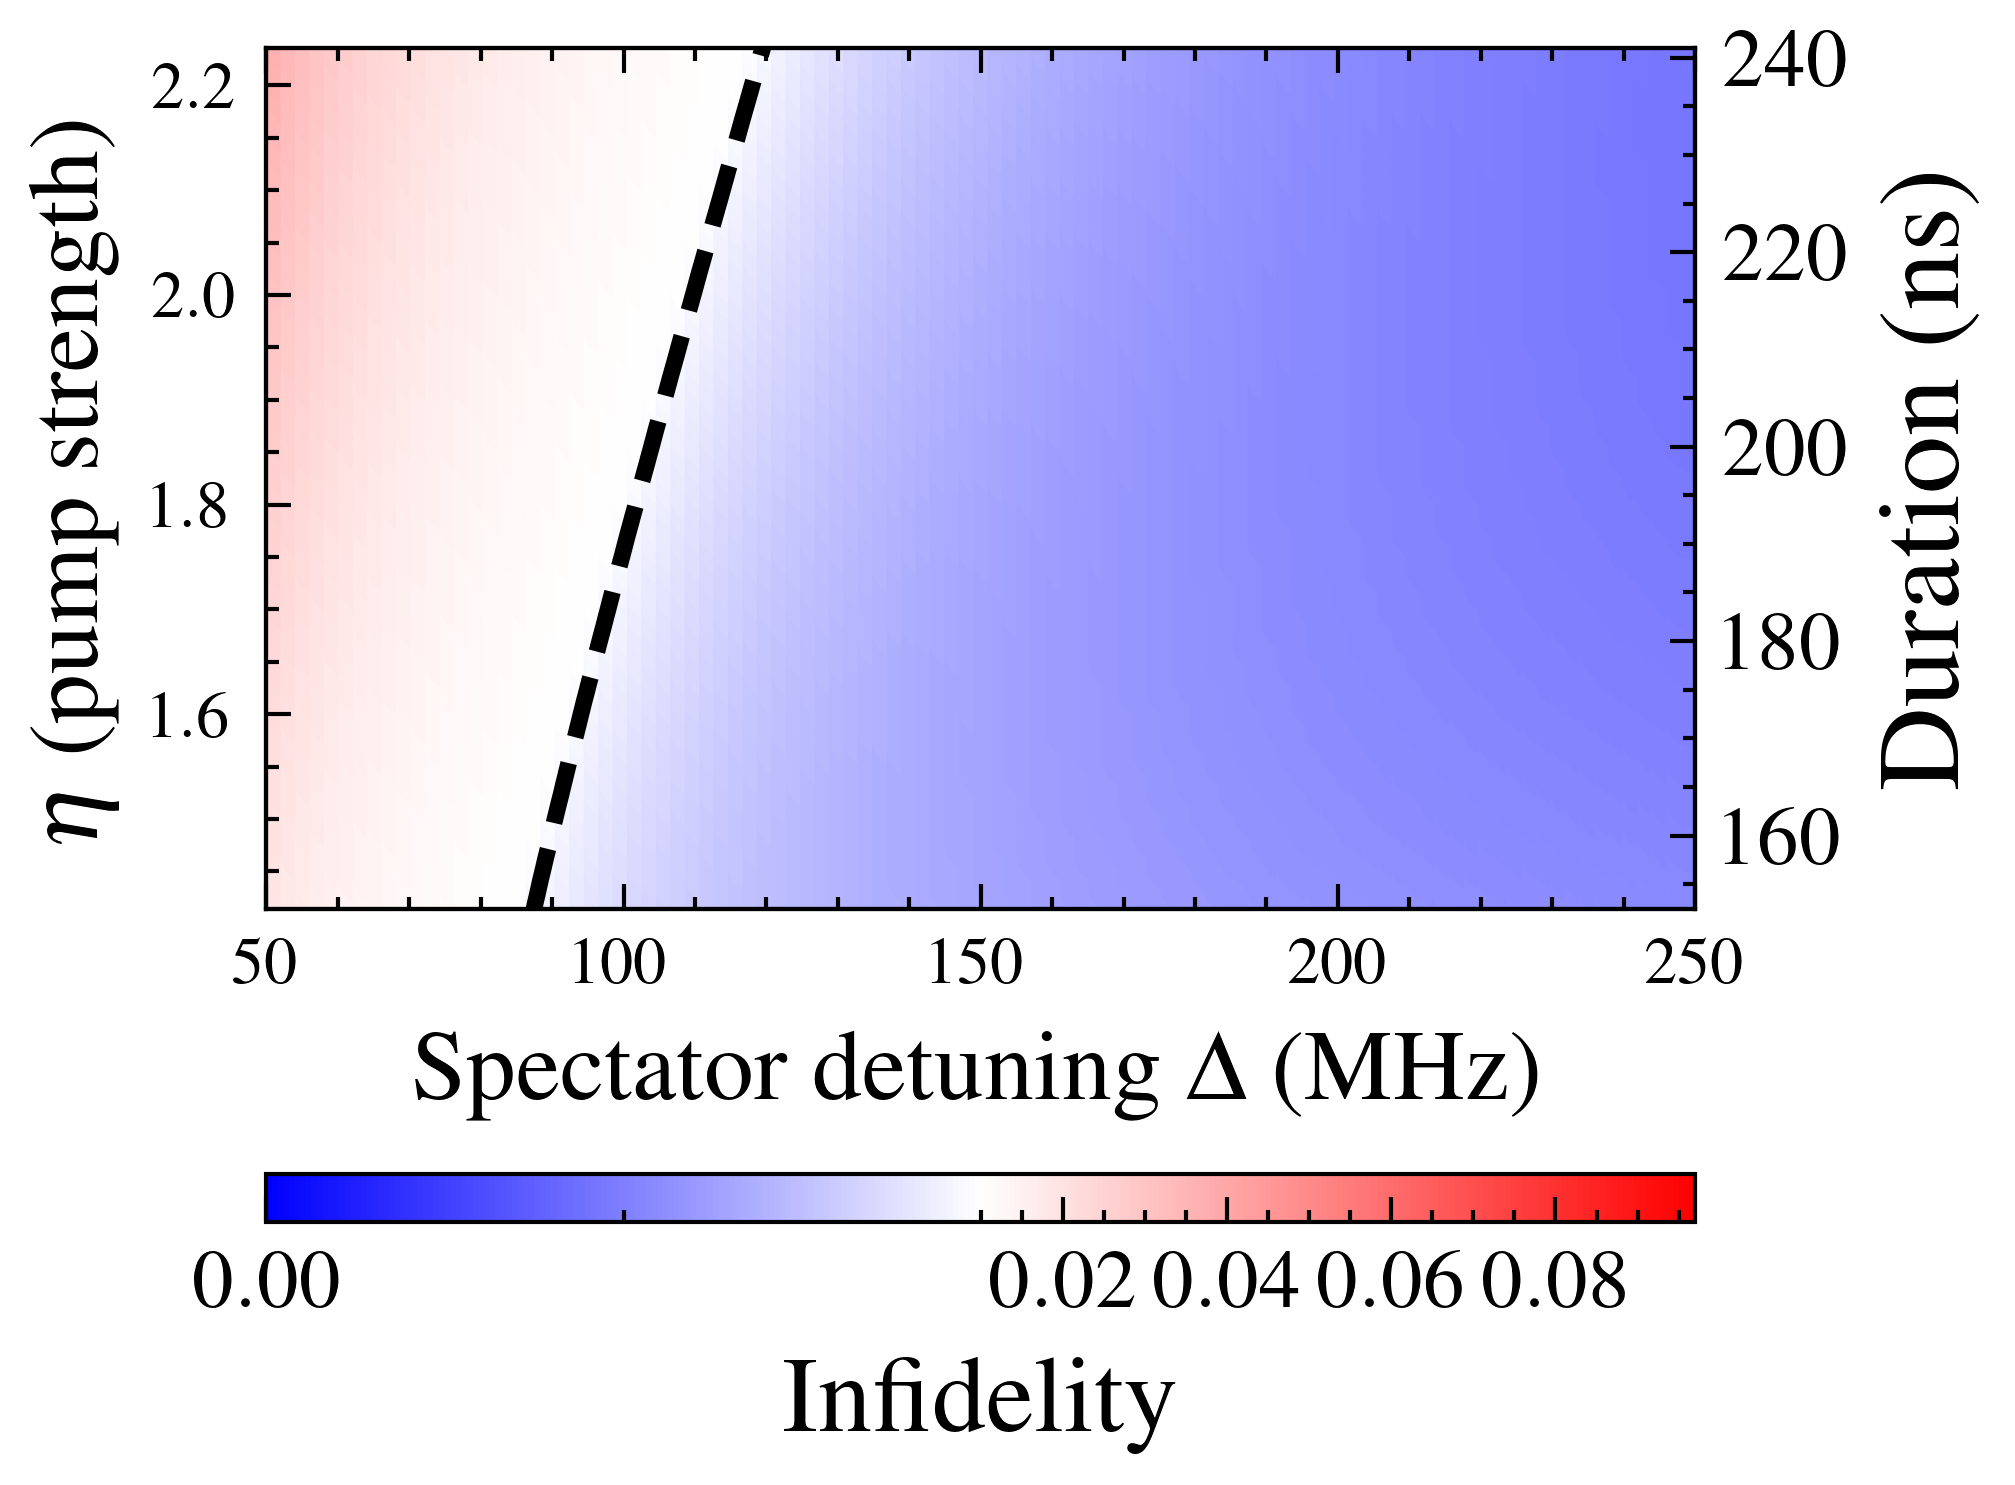

Saved: sqrt{iSWAP}_lambda_008_T1_100_us.pdf


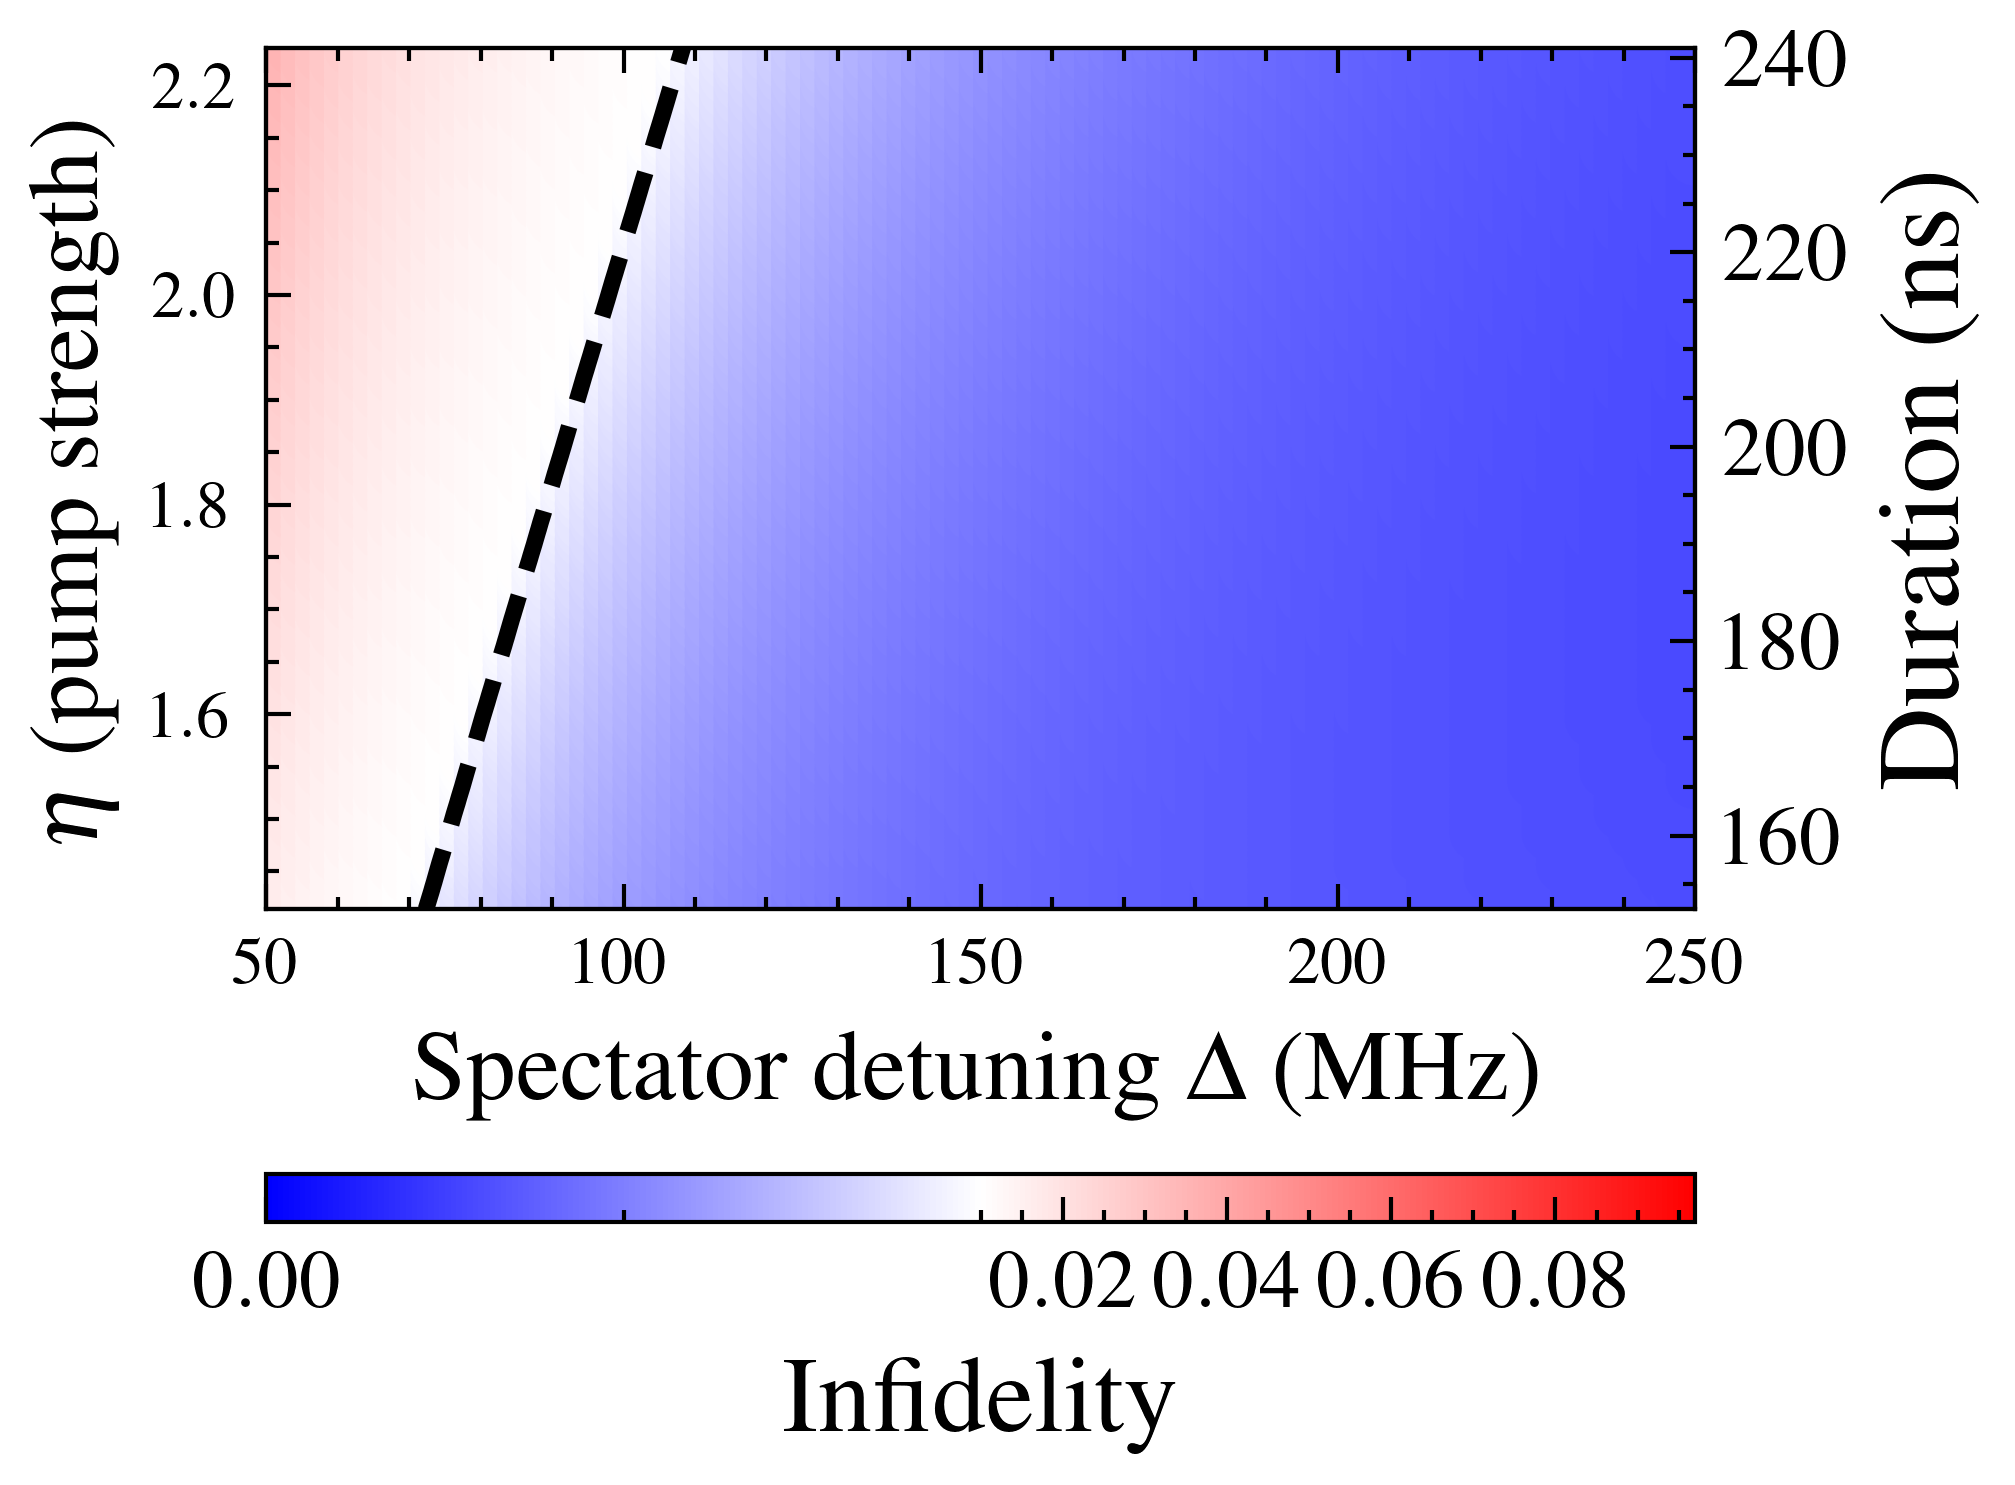

Saved: sqrt{iSWAP}_lambda_01_T1_50_us.pdf


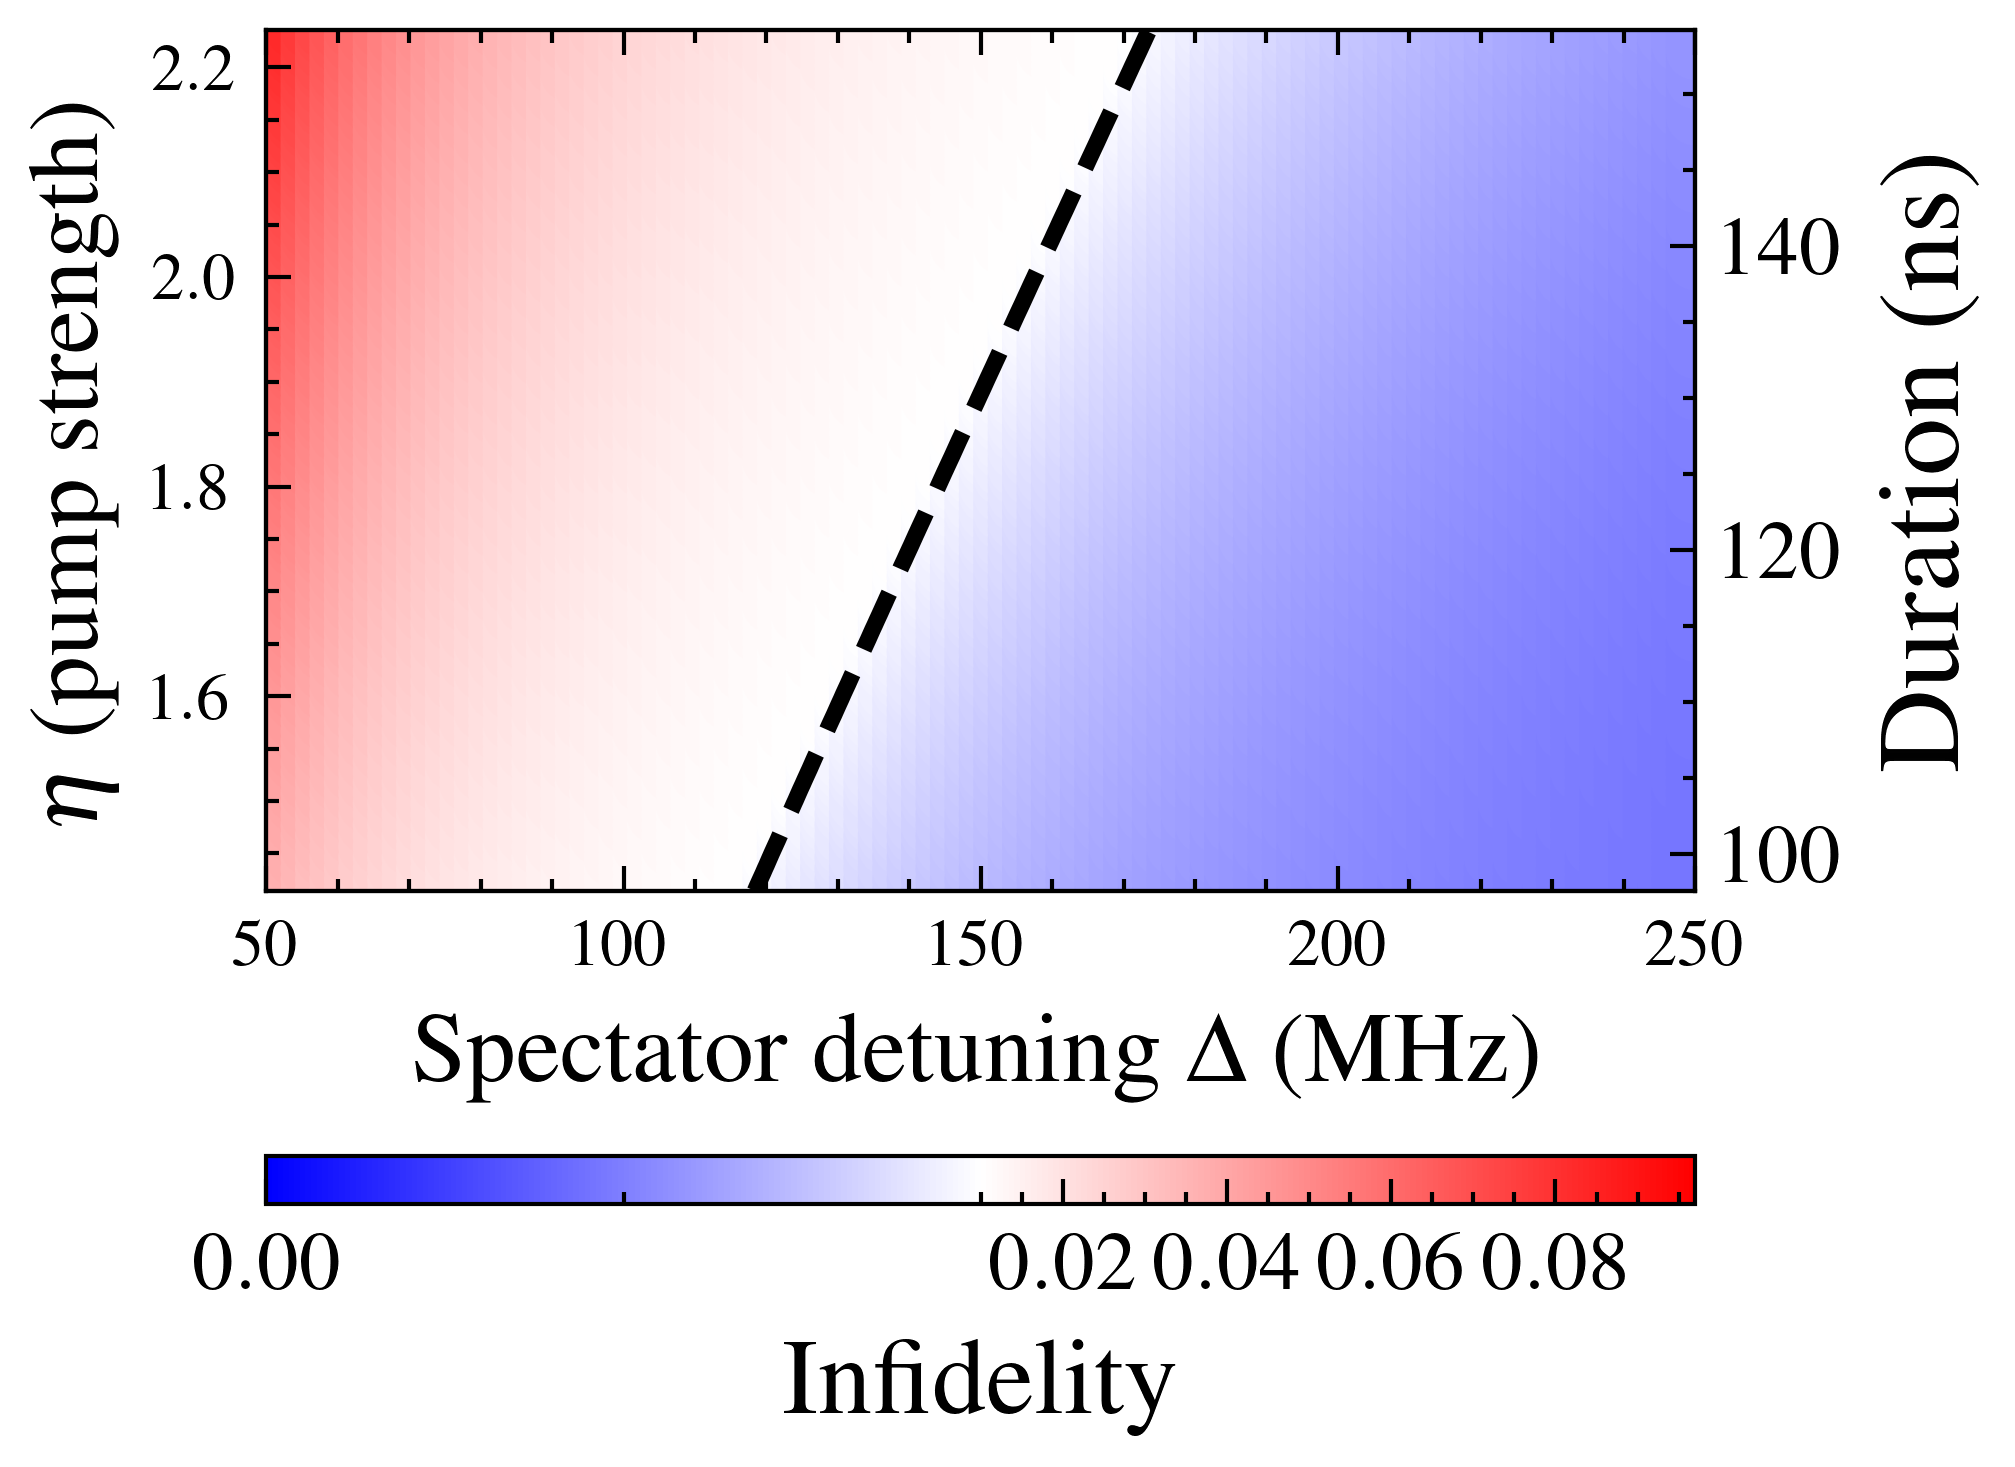

Saved: sqrt{iSWAP}_lambda_01_T1_100_us.pdf


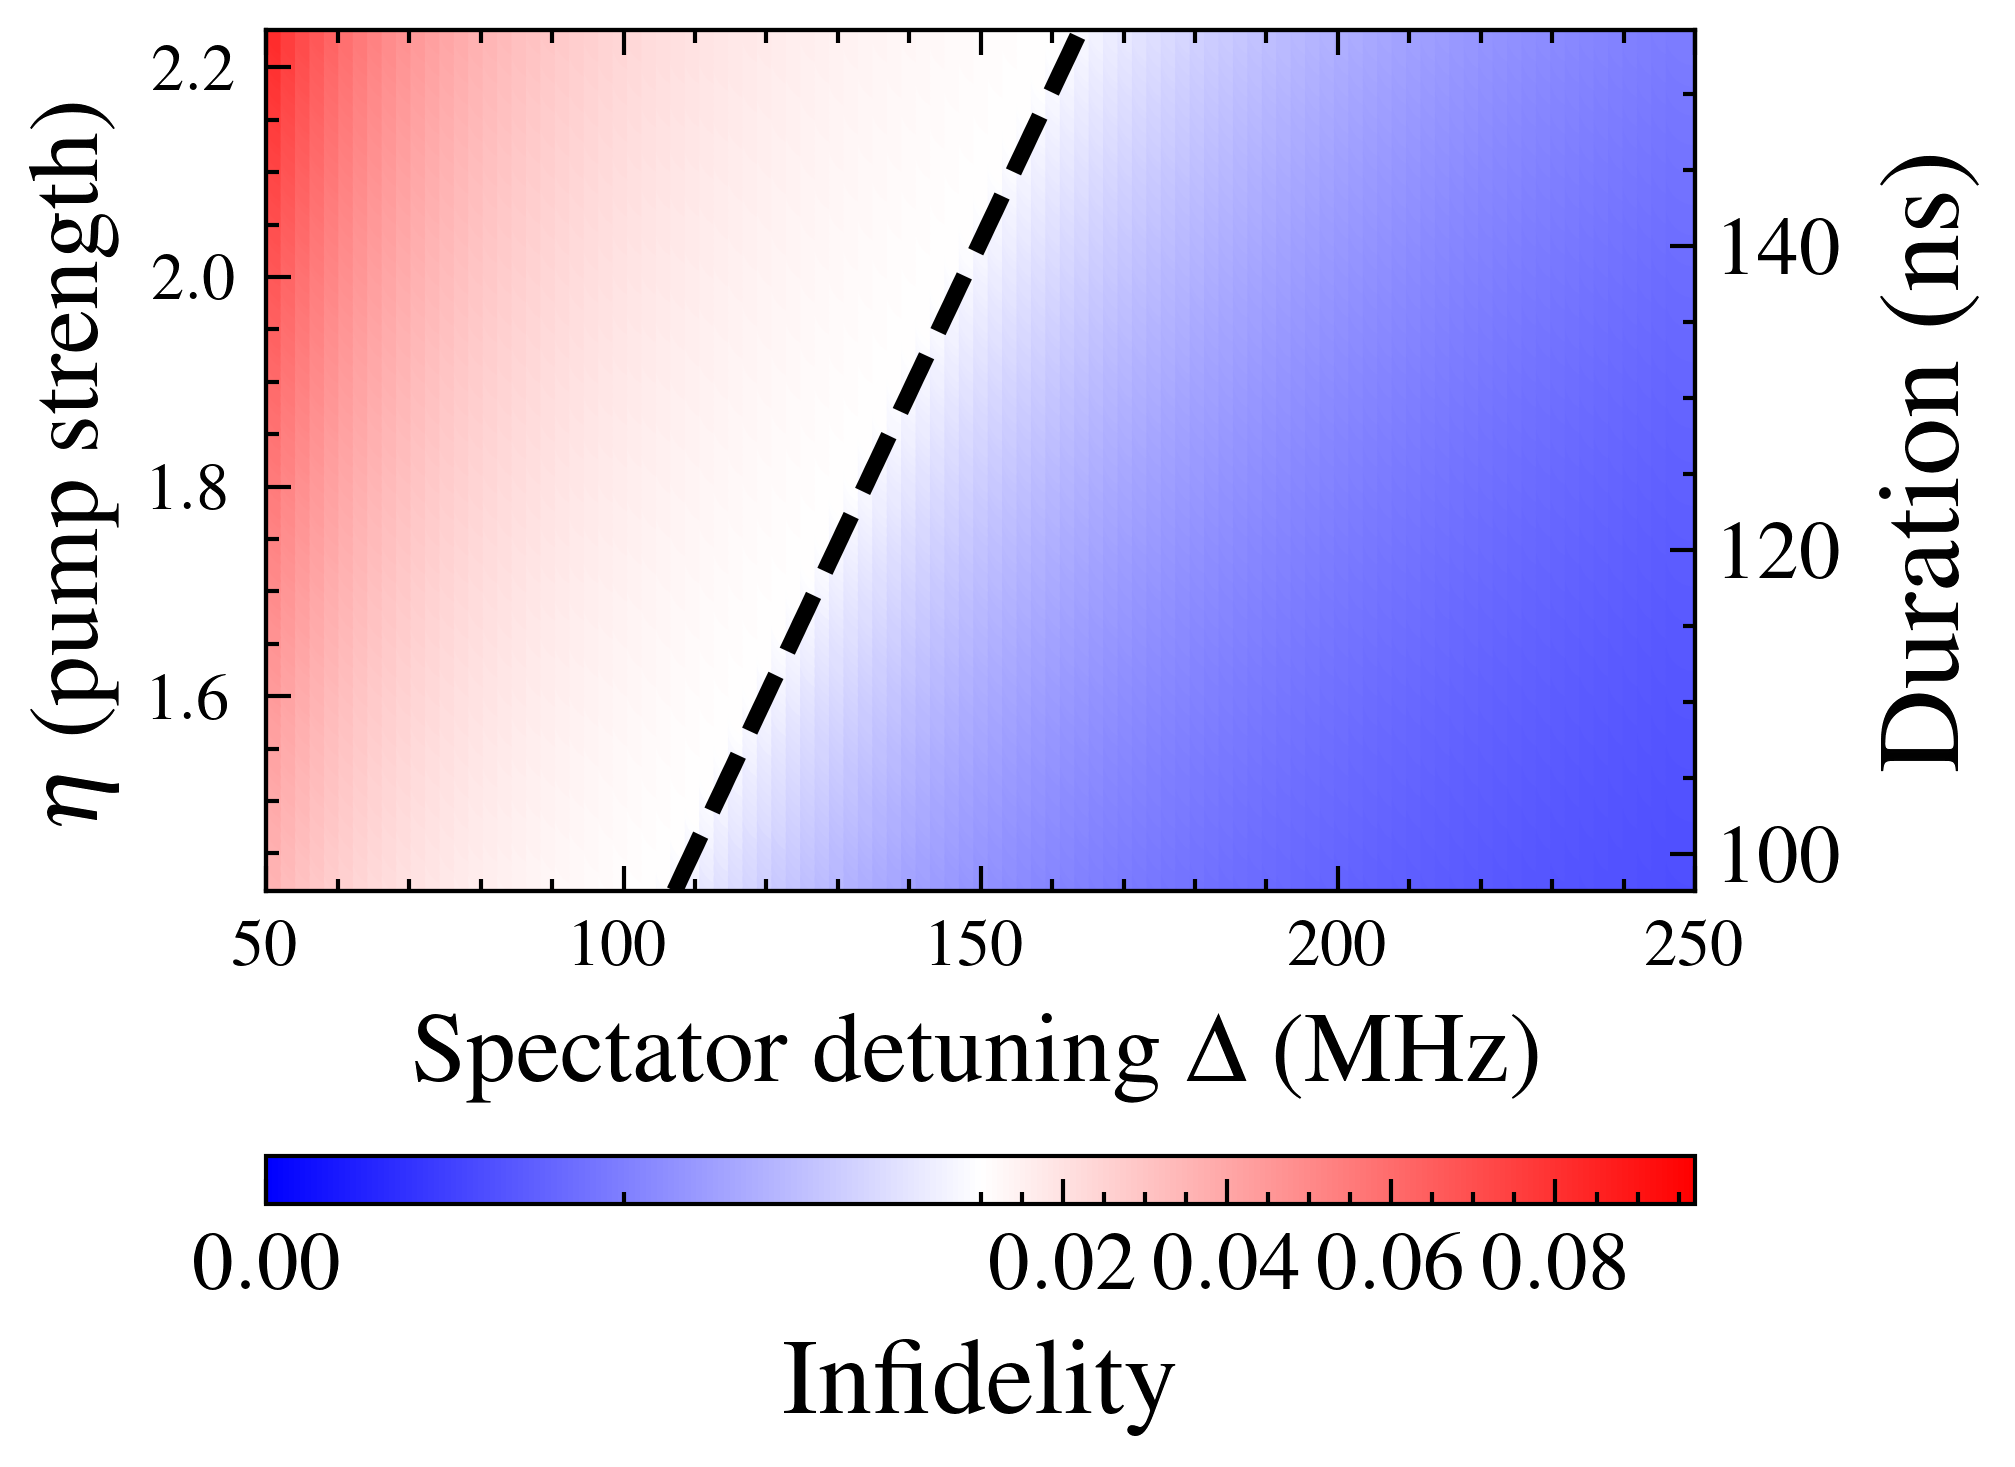

In [24]:
# Step 2: Plot Data
# First, determine global min and max fidelity
all_fidelities = np.concatenate([d["fidelity_list"] for d in data_store])
global_vmin, global_vmax = 0.0, np.max(all_fidelities)

# Now plot all data using the global color bar range
for data in data_store:
    gate_type = data["gate_type"]
    lambdaq = data["lambdaq"]
    T1 = data["T1"]
    fidelity_array = data["fidelity_list"]
    eta_array = data["n_s_points"]
    delta_array = data["delta_points"]
    gate_durations = data["gate_durations"]

    # Plotting configuration
    norm = TwoSlopeNorm(
        vmin=global_vmin, vcenter=(1 - target_fidelity), vmax=global_vmax
    )

    # Plotting
    with plt.style.context(["ieee", "use_mathtext", "science"]):
        fig, ax1 = plt.subplots()  # Adjust figure size for better proportions

        # Scatter plot for fidelity
        sc = ax1.scatter(
            delta_array, eta_array, c=fidelity_array, cmap="bwr", norm=norm, marker="o"
        )

        # Horizontal color bar below the plot
        cbar = plt.colorbar(
            sc, orientation="horizontal", pad=0.2, aspect=30
        )  # Adjust 'aspect' for length
        cbar.set_label("Infidelity", fontsize=13)  # Adjust color bar label size
        cbar.ax.tick_params(labelsize=10)  # Adjust tick label size on color bar

        # Labels for the main plot
        ax1.set_xlabel(
            r"Spectator detuning $\Delta$ (MHz)", fontsize=12
        )  # Increase font size for x-axis
        ax1.set_ylabel(
            r"$\eta$ (pump strength)", fontsize=12
        )  # Increase font size for y-axis
        # ax1.set_title(r'{} ( $\lambda = {:.2f}$, $T_1 = {:.0f} \, \mu$s )'.format(gate_type, lambdaq, T1 * 1e6), fontsize=16)  # Adjust title size and padding

        # Second y-axis for gate duration
        ax2 = ax1.twinx()
        ax2.set_ylabel(
            r"Duration (ns)", fontsize=14
        )  # Increase font size for the second y-axis
        ax2.set_ylim(np.min(gate_durations), np.max(gate_durations))
        ax2.tick_params(labelsize=10)  # Adjust the tick label size on the second y-axis

        # Contour for target fidelity (e.g., 0.99)
        if global_vmin <= (1 - target_fidelity) <= global_vmax:
            triang = tri.Triangulation(delta_array, eta_array)
            ax1.tricontour(
                triang,
                fidelity_array,
                levels=[1 - target_fidelity],
                colors="black",
                linewidths=2,
                linestyles="dashed",
            )
        else:
            print(
                f"Warning: Target infidelity {1 - target_fidelity} is outside the range of calculated fidelities."
            )

        # Adjust layout to ensure everything fits well
        fig.tight_layout()

        # Save the plot as an SVG file with a unique filename
        plot_filename = f"{gate_type}_lambda_{lambdaq}_T1_{int(T1 * 1e6)}_us"
        plot_filename = (
            plot_filename.replace("\\", "").replace("$", "").replace(".", "") + ".pdf"
        )

        plt.savefig(plot_filename)
        print(f"Saved: {plot_filename}")
        plt.show();

In [5]:
# import numpy as np
# from qutip import destroy, tensor, qeye, average_gate_fidelity
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt
# from matplotlib.colors import TwoSlopeNorm
# import matplotlib.tri as tri

# # Parameters for the simulation
# target_fidelity = 0.99  # Target fidelity (e.g., 99%)
# N = 50  # Number of data points for fidelity plots
# g3 = 60e6  # Coupling strength g3 = 60 MHz
# alpha = 100e6
# T1 = 80e-6  # Qubit lifetime in seconds (100 µs)
# lambdaq = 0.1  # Coupling strength parameter
# n_s_list = np.linspace(2, 5, N)  # Pump photon number values
# delta_list = 1e6 * np.linspace(100, 300, N)  # Detuning values in Hz

# # Option to choose between iSWAP and sqrt(iSWAP)
# iswap_choice = False  # Set to False for sqrt(iSWAP)
# if iswap_choice:
#     full_pulse = np.pi / 2  # pi/2 pulse for iSWAP
#     intended_gate = ISWAP([0, 1]).get_compact_qobj()
# else:
#     full_pulse = np.pi / 4  # pi/4 pulse for sqrt(iSWAP)
#     intended_gate = SQRTISWAP([0, 1]).get_compact_qobj()

# # Fidelity and gate duration data storage
# fidelity_list = []
# n_s_points = []
# delta_points = []
# gate_durations = []

# # Define ladder operators for the qubits
# q = destroy(2)
# q1 = tensor(q, qeye(2), qeye(8))
# q2 = tensor(qeye(2), q, qeye(8))
# s = tensor(qeye(2), qeye(2), destroy(8))
# q1dag, q2dag, sdag = q1.dag(), q2.dag(), s.dag()

# # Interaction and spectator terms
# interaction_term = q1dag * q2 + q1 * q2dag
# spectator_term = q1dag * s + q1 * sdag

# # Fidelity calculation loop
# for delta in tqdm(delta_list):
#     for n_s in n_s_list:
#         eta = np.sqrt(n_s)
#         g_eff = 6 * eta * g3 * (lambdaq**2)  # Effective coupling
#         t_f = full_pulse / g_eff  # Gate duration in seconds
#         t_f_ns = t_f * 1e9  # Convert gate duration to nanoseconds

#         # Spectator term prefactor and integral term
#         multiple_scale_factor = np.sqrt(2)  # This accounts for a crowding term both above and below the desired interaction
#         integral_term = 2 / delta  # Worst-case, magnitude from time-dependent phase integral
#         spectator_prefactor = 6 * eta * g3 * (lambdaq) - eta**2 * alpha * lambdaq**3

#         # Time evolution operator U(t_f)
#         U_t_f = (
#             1j * g_eff * (t_f * interaction_term) + 1j * (multiple_scale_factor * integral_term * spectator_prefactor * spectator_term)
#         ).expm()

#         # U_t_f project into the 2-qubit subspace
#         U_t_f = U_t_f.ptrace([0, 1])
#         target_iswap = tensor(intended_gate)
#         fidelity = 1 - (average_gate_fidelity(U_t_f, target_iswap) * np.exp(-t_f / T1))

#         # Store fidelity, eta, delta, and gate duration
#         fidelity_list.append(fidelity)
#         n_s_points.append(eta)  # Use eta (sqrt of n_s) for plotting
#         delta_points.append(delta / 1e6)  # Convert delta to MHz for plotting
#         gate_durations.append(t_f_ns)  # Store gate duration in nanoseconds

# # Convert to NumPy arrays for plotting
# fidelity_array = np.array(fidelity_list)
# eta_array = np.array(n_s_points)
# delta_array = np.array(delta_points)
# gate_durations = np.array(gate_durations)

# # Plotting configuration
# vmin, vmax = np.min(fidelity_array), np.max(fidelity_array)
# norm = TwoSlopeNorm(vmin=0, vcenter=(1-target_fidelity), vmax=vmax)

# # Plotting
# with plt.style.context(["ieee", "use_mathtext", 'science']):
#     fig, ax1 = plt.subplots()

#     # Scatter plot for fidelity
#     sc = ax1.scatter(delta_array, eta_array, c=fidelity_array, cmap='coolwarm', norm=norm, marker='o')
#     plt.colorbar(sc, label='Infidelity')

#     # Labels for the main plot
#     ax1.set_xlabel('Detuning (MHz)')
#     ax1.set_ylabel('eta (effective pump strength)')
#     ax1.set_title(f'Fidelity vs Detuning and eta (lambda = {lambdaq}, T1 = {T1 * 1e6:.0f} µs)')

#     # Second y-axis for gate duration
#     ax2 = ax1.twinx()
#     ax2.set_ylabel('Gate Duration $t_f$ (ns)')
#     ax2.set_ylim(np.min(gate_durations), np.max(gate_durations))

#     # Contour for target fidelity (e.g., 0.99)
#     if vmin <= (1-target_fidelity) <= vmax:
#         triang = tri.Triangulation(delta_array, eta_array)
#         ax1.tricontour(triang, fidelity_array, levels=[1-target_fidelity], colors='black', linewidths=1.5, linestyles='dashed')
#     else:
#         print(f"Warning: Target infidelity {1-target_fidelity} is outside the range of calculated fidelities.")

#     fig.tight_layout()
#     plt.show()

In [6]:
# import numpy as np
# from qutip import destroy, tensor, qeye, process_fidelity, average_gate_fidelity
# from qutip_qip.operations import ISWAP, SQRTISWAP
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt
# import scienceplots

# N = 50

# # define qutip ladder operators
# q = destroy(2)
# q1 = tensor(q, qeye(2), qeye(2), qeye(2))
# q2 = tensor(qeye(2), q, qeye(2), qeye(2))
# q3 = tensor(qeye(2), qeye(2), q, qeye(2))
# q4 = tensor(qeye(2), qeye(2), qeye(2), q)
# q1dag = q1.dag()
# q2dag = q2.dag()
# q3dag = q3.dag()
# q4dag = q4.dag()


# # full_pulse = geff * t_f => geff = full_pulse / t_f
#  # pi/2 pulse for iSWAP, pi/4 for sqrtiSWAP
# if True:
#     full_pulse = np.pi / 2
#     intended_gate = ISWAP([0,1]).get_compact_qobj()
# else:
#     full_pulse = np.pi / 4
#     intended_gate = SQRTISWAP([0,1]).get_compact_qobj()

# n_s_list = np.linspace(2, 5, N)  # sqrt of pump photon number in SNAIL mode
# delta_list = 1e6 * np.linspace(0.001, 10, 8)  # MHz
# fidelity_dict = {}  # to store fidelity values for each delta
# tf_dict = {}  # to store g_eff values for each delta

# # params
# g3 = 60e6  # (g3 = 60 Mhz / 2pi)
# lambdaq = 0.1

# for delta in tqdm(delta_list):
#     fidelity_list = []
#     tf_list = []  # store g_eff for this delta
#     for n_s in n_s_list:
#         eta = np.sqrt(n_s)
#         g_eff = 6 * eta * g3 * (lambdaq**2)
#         t_f = full_pulse / g_eff

#         # H(t) = g_eff * exp(-i * delta * t) * interaction_term
#         interaction_term = q1dag * q2 + q1 * q2dag
#         spectator_term = q3dag * q4 + q3 * q4dag


#         # Integral of the exponential factor
#         # integral_term = (1j *(-1 + np.cos(t_f * delta)))/delta + np.sin(t_f * delta)/delta
#         integral_term = 2 * np.sin(t_f * delta / 2) / delta

#         # neighbor_module
#         integral_term *= lambdaq**2

#         # Time evolution operator U(t_f)
#         # NOTE sqrt(2) to scale to scale spectator to be on both left and right of intended
#         multiple_scale_factor = np.sqrt(8)
#         U_t_f = (
#             1j
#             * g_eff
#             * (t_f * interaction_term +
#                multiple_scale_factor * integral_term * (spectator_term))
#         ).expm()


#         # Fidelity calculation
#         # Define the target iSWAP gate
#         # target_iswap = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
#         target_iswap = tensor(intended_gate, qeye([2, 2]))
#         fidelity = 1 - average_gate_fidelity(U_t_f, target_iswap)
#         fidelity_list.append(fidelity)
#         tf_list.append(t_f)

#     # Store fidelity list and g_eff list for current delta
#     fidelity_dict[delta] = fidelity_list
#     tf_dict[delta] = tf_list


# from matplotlib import rc
# with plt.style.context(["ieee", "use_mathtext", 'science']):
#     # rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

#     # Plotting fidelity as a function of g_eff for each delta
#     for delta, fidelity_list in fidelity_dict.items():
#         tf_list = np.array(tf_dict[delta]) * 1e9  # convert to ns
#         plt.plot(tf_list, fidelity_list, label=f"Delta = {delta/1e6:.0f} MHz", marker=".")
#         # plt.plot(
#         #     tf_list,
#         #     len(fidelity_list) * [np.max(fidelity_list)],
#         #     marker=".",
#         #     color="gray",
#         #     alpha=0.3,
#         # )
#         # plot hline at 1-.999
#         plt.axhline(1-.999, color="gray", linestyle="--", alpha=0.3)

#     # set xaxis to use ns instead of scientific notation
#     plt.ticklabel_format(style="plain", axis="x")
#     plt.xlabel("Duration (ns)")
#     plt.ylabel("Infidelity")
#     plt.title("Infidelity (iswap_12) vs Duration for spectator(_34) detunings")
#     plt.legend(ncols=len(fidelity_dict) // 4, bbox_to_anchor=(.75, -.15))
#     plt.show()

In [7]:
# import numpy as np
# from qutip import destroy, tensor, qeye, average_gate_fidelity
# from qutip_qip.operations import ISWAP, SQRTISWAP
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt

# # Define qutip ladder operators
# q = destroy(2)
# q1 = tensor(q, qeye(2), qeye(2), qeye(2))
# q2 = tensor(qeye(2), q, qeye(2), qeye(2))
# q3 = tensor(qeye(2), qeye(2), q, qeye(2))
# q4 = tensor(qeye(2), qeye(2), qeye(2), q)
# q1dag = q1.dag()
# q2dag = q2.dag()
# q3dag = q3.dag()
# q4dag = q4.dag()

# # Use a pi/4 pulse for sqrt(iSWAP)
# full_pulse = np.pi / 4
# intended_gate = SQRTISWAP([0,1]).get_compact_qobj()

# # Parameters
# delta_list = 1e6 * np.linspace(150, 400, 200)  # Fine-grained detuning (MHz)
# g3 = 60e6  # g3 = 60 MHz
# lambdaq = 0.08  # lambda parameter
# t_f_fixed_ns = 100  # Fixed gate duration in ns
# t_f_fixed = t_f_fixed_ns * 1e-9  # Convert ns to seconds

# fidelity_list = []  # Store fidelity values

# # Calculate eta and fidelity for each delta
# for delta in tqdm(delta_list):
#     g_eff = full_pulse / t_f_fixed  # Calculate g_eff based on fixed t_f
#     eta = g_eff / (6 * g3 * (lambdaq ** 2))  # Calculate eta

#     # Interaction and spectator terms
#     interaction_term = q1dag * q2 + q1 * q2dag
#     spectator_term = q3dag * q4 + q3 * q4dag

#     # Integral of the exponential factor
#     integral_term = 2 * np.sin(t_f_fixed * delta / 2) / delta

#     # Time evolution operator U(t_f)
#     multiple_scale_factor = np.sqrt(2)
#     U_t_f = (
#         1j
#         * g_eff
#         * (t_f_fixed * interaction_term +
#            multiple_scale_factor * integral_term * (spectator_term))
#     ).expm()

#     # Fidelity calculation
#     target_iswap = tensor(intended_gate, qeye([2, 2]))
#     fidelity = 1 - average_gate_fidelity(U_t_f, target_iswap)
#     fidelity_list.append(fidelity)

# # Plotting infidelity vs delta
# with plt.style.context(["ieee", "use_mathtext", 'science']):

#     plt.plot(delta_list / 1e6, fidelity_list, marker="o", label=f"t_f = {t_f_fixed_ns} ns")
#     plt.axhline(1 - 0.999, color="gray", linestyle="--", alpha=0.3)

#     # Labels and title
#     plt.xlabel("Detuning (MHz)")
#     plt.ylabel("Infidelity")
#     # y-log
#     plt.yscale('log')
#     plt.title("Infidelity vs Detuning (Fixed t_f = 100 ns)")
#     plt.legend()
#     plt.grid(True)

#     # Show plot
#     plt.show()

In [8]:
# import numpy as np
# from qutip import destroy, tensor, qeye, average_gate_fidelity
# from qutip_qip.operations import ISWAP, SQRTISWAP
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt

# N = 50

# # Define qutip ladder operators
# q = destroy(2)
# q1 = tensor(q, qeye(2), qeye(2), qeye(2))
# q2 = tensor(qeye(2), q, qeye(2), qeye(2))
# q3 = tensor(qeye(2), qeye(2), q, qeye(2))
# q4 = tensor(qeye(2), qeye(2), qeye(2), q)
# q1dag = q1.dag()
# q2dag = q2.dag()
# q3dag = q3.dag()
# q4dag = q4.dag()

# # Full pulse: pi/2 for iSWAP, pi/4 for sqrt(iSWAP)
# if True:
#     full_pulse = np.pi / 2
#     intended_gate = ISWAP([0, 1]).get_compact_qobj()
# else:
#     full_pulse = np.pi / 4
#     intended_gate = SQRTISWAP([0, 1]).get_compact_qobj()

# # Parameters
# lambda_list = [0.08, 0.09, 0.1]  # Different lambda values for separate plots
# n_s_list = np.linspace(2, 5, N)  # Fine-grained sweep for pump photon number (x-axis)
# delta_list = 1e6 * np.linspace(100, 400, 8)  # 8 detuning values (MHz) for separate lines
# fidelity_dict = {}  # To store fidelity values for each lambda and delta

# # Parameters for the system
# g3 = 60e6  # g3 = 60 MHz
# T1 = 100e-6  # Lifetime of qubit is 100 us

# for lambdaq in lambda_list:
#     fidelity_dict[lambdaq] = {}  # Initialize a new dict for each lambda
#     for delta in tqdm(delta_list):
#         fidelity_list_for_delta = []
#         for n_s in n_s_list:
#             eta = np.sqrt(n_s)
#             g_eff = 6 * eta * g3 * (lambdaq**2)
#             t_f = full_pulse / g_eff  # Duration of the gate

#             # Interaction and spectator terms
#             interaction_term = q1dag * q2 + q1 * q2dag
#             spectator_term = q3dag * q4 + q3 * q4dag

#             # Worst-case spectator approximation
#             integral_term = 2 / delta  # Worst-case where sin(t_f * delta / 2) = 1

#             # Time evolution operator U(t_f)
#             multiple_scale_factor = np.sqrt(2)
#             U_t_f = (
#                 1j
#                 * g_eff
#                 * (t_f * interaction_term +
#                    multiple_scale_factor * integral_term * (spectator_term))
#             ).expm()

#             # Fidelity calculation with lifetime decay
#             target_iswap = tensor(intended_gate, qeye([2, 2]))
#             fidelity = 1 - (average_gate_fidelity(U_t_f, target_iswap) * np.exp(-t_f / T1))

#             # Store fidelity
#             fidelity_list_for_delta.append(fidelity)

#         # Store fidelity list for this delta under current lambda
#         fidelity_dict[lambdaq][delta] = fidelity_list_for_delta

# # Plotting
# with plt.style.context(["ieee", "use_mathtext", 'science']):

#     # Generate separate plots for each lambda
#     for lambdaq in lambda_list:

#         # Plot fidelity as a function of n_s for different delta values
#         for delta, fidelity_data in fidelity_dict[lambdaq].items():
#             plt.plot(n_s_list, fidelity_data, label=f"Delta = {delta/1e6:.0f} MHz", marker=".")
#             # horizontal line at 1 - 0.99
#             plt.axhline(1 - 0.99, color="gray", linestyle="--", alpha=0.3)

#         # Labels and titles
#         plt.xlabel('n_s (Pump Photon Number)')
#         plt.ylabel('Intra-module spectator infidelity')
#         plt.title(f'Infidelity vs n_s for Lambda = {lambdaq:.2f}')
#         plt.legend(ncols=len(delta_list) // 4, bbox_to_anchor=(.75, -.15))
#         plt.grid(True)

#         # Display each plot
#         plt.show()